# Traffic Car and People Detection

## Importing Modules

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import keras
import os
import matplotlib.pyplot as plt
import cv2
from PIL import Image, ImageDraw
from sklearn.cluster import KMeans

## Resizing Images

In [2]:
def ResizingScaling(ImagePath, LabelPath, NewShape=(448, 448)):

    # Read the image file
    file = tf.io.read_file(ImagePath)
    
    # Decode the image as a tensor
    image = tf.image.decode_image(file, channels=3)

    # Resize the image to the new shape
    image = tf.image.resize(image, NewShape)

    # Normalize the pixel values of the image to the range [0, 1]
    image = image / 255.0

    # Calculate the scaling factors for the labels
    ScaleFactorX = NewShape[0] / image.shape[0]
    ScaleFactorY = NewShape[1] / image.shape[1]

    TotalLabels = []

   
    with open(LabelPath, 'r') as handle:
        Labels = handle.readlines()

        
        for label in Labels:
           
            label = label.replace('\n', '').split()
            label[0] = int(label[0]) 
            label[1] = float(label[1]) * ScaleFactorX  
            label[2] = float(label[2]) * ScaleFactorY  
            label[3] = float(label[3]) * ScaleFactorX 
            label[4] = float(label[4]) * ScaleFactorY  

           
            TotalLabels.append(label)
            
    return [image, TotalLabels]  

## Plotting Boxes in Images

In [3]:
def PlotBoundingBoxes(ImageTensor, boxes):

    
    # Convert the image tensor to a NumPy array if it is a TensorFlow tensor
    if isinstance(ImageTensor, tf.Tensor):
        ImageTensor = ImageTensor.numpy()

    # Convert a grayscale image to RGB if needed (to display the bounding boxes in red)
    if len(ImageTensor.shape) == 2:
        ImageTensor = np.stack((ImageTensor) * 3, axis=-1)

    # Create a copy of the image to draw the bounding boxes on
    ImageBoxes = np.copy(ImageTensor)

    # Set the color and thickness of the bounding boxes
    box_color = (0, 0,255) 
    thickness = 2  

    # Convert the image to a PIL image for drawing
    image_pil = Image.fromarray(np.uint8(ImageBoxes))
    draw = ImageDraw.Draw(image_pil)

    # Iterate over each bounding box and draw it on the image
    for box in boxes:
        cx, cy, w, h = box

        # Convert the normalized bounding box coordinates to absolute pixel values
        image_height, image_width = ImageTensor.shape[:2]
        box_x = int(cx * image_width)
        box_y = int(cy * image_height)
        box_width = int(w * image_width)
        box_height = int(h * image_height)

        # Calculate the top-left and bottom-right coordinates of the bounding box
        top_left = (box_x - box_width // 2, box_y - box_height // 2)
        bottom_right = (box_x + box_width // 2, box_y + box_height // 2)

        # Draw the bounding box on the image
        draw.rectangle([top_left, bottom_right], outline=box_color, width=thickness)

    # Convert the image back to a NumPy array
    ImageBoxes = np.array(image_pil)

    
    plt.imshow(ImageBoxes)
    plt.axis('off') 
    plt.show()

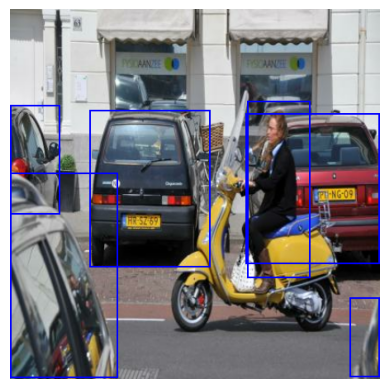

In [4]:
MainPath = r"C:\Users\LENEVO\OneDrive\Desktop\Assignment 3\train"
ImgPath = os.path.join(MainPath, r"C:\Users\LENEVO\OneDrive\Desktop\Assignment 3\train\images\image_000000147_jpg.rf.ae3ab2433fd58e159e6177b456e99ab8.jpg")
LabelPath = os.path.join(MainPath, r"C:\Users\LENEVO\OneDrive\Desktop\Assignment 3\train\labels\image_000000147_jpg.rf.ae3ab2433fd58e159e6177b456e99ab8.txt")

image, labels = ResizingScaling(ImgPath, LabelPath, NewShape=(448, 448))

boxes = [x[1:5] for x in labels]

PlotBoundingBoxes(image * 255.0, boxes)

## Iterating through dataset

In [5]:
def kmeans_anchors(FilePath, num_anchors, num_iterations=1200):
    
    files = os.listdir(FilePath)

    
    boxes = []
    for file in files:
        with open(os.path.join(FilePath, file), 'r') as handle:
            labels = handle.readlines()
           
        for label in labels:
            label = label.strip().split()
            box = label[3:] 
            boxes.append(box)
            
   
    kmeans = KMeans(n_clusters=num_anchors, max_iter=num_iterations)
    kmeans.fit(boxes)
    anchor_boxes = kmeans.cluster_centers_

    return anchor_boxes

In [9]:
def GroundLabel(input_size, labels, anchor_boxes, classes):
    anchors = len(anchor_boxes)
    grid_shape = (7,7) 
    
    GroundLabels = np.zeros((grid_shape[0], grid_shape[1], anchors, 5 + classes))
    
    for label in labels:
        idx, cx, cy, w, h = label

        
        gridX = int(cx * (grid_shape[1]))
        gridY = int(cy * (grid_shape[0]))
        
       
        WidthImg = w * input_size[1] / grid_shape[1]
        HieghtImg = h * input_size[0] / grid_shape[0]
        
        
        BestAnchor = -10
        BestIOU = -10
        
        for idxA, anchor in enumerate(anchor_boxes):
            widthA, heightA = anchor
            intersection_height = min(cy + h / 2, cy + heightA / 2) - max(cx - h / 2, cx - heightA / 2)
            intersection_width = min(cx + w / 2, cx + widthA / 2) - max(cx - w / 2, cx - widthA / 2)
            intersection = intersection_width * intersection_height
            union = (w * h) + (widthA * heightA) - intersection
            iou = intersection / union
            if iou > BestIOU :
                BestIOU = iou
                BestAnchor = idxA
                
      
        GroundLabels[ gridY, gridX, BestAnchor, 0] = 1.0  
        GroundLabels[ gridY, gridX, BestAnchor, 1] = cx * grid_shape[1] - gridX
        GroundLabels[ gridY, gridX, BestAnchor, 2] = cy * grid_shape[0] -  gridY
        GroundLabels[ gridY, gridX, BestAnchor, 3] = WidthImg 
        GroundLabels[ gridY, gridX, BestAnchor, 4] = HieghtImg 
        GroundLabels[ gridY, gridX, BestAnchor, 5 + idx] = 1.0

    return GroundLabels.reshape((grid_shape[0], grid_shape[1], anchors * (5 + classes)))

## Processing Images

In [10]:
def preprocess(image_path, label_path, new_shape, anchor, classes):
    images = os.listdir(image_path)
    labels = os.listdir(label_path)
    X, Y = [], []
    
    for image in images: 
        img_name, ext = os.path.splitext(image)
        TextFile = img_name + ".txt"

        FullImagePath = os.path.join(image_path, image)
        FullLabelPath = os.path.join(label_path, TextFile)

        if os.path.isfile(FullLabelPath):
            image_tensor, labels = ResizingScaling(FullImagePath, FullLabelPath, NewShape=(448, 448))
            ground_label= GroundLabel((445, 445), labels, anchor, classes)
            
            X.append(image_tensor)
            Y.append(ground_label)
            
        else:
            pass
        
    return np.array(X), np.array(Y)

In [11]:
TrainImg = r"C:\Users\LENEVO\OneDrive\Desktop\Assignment 3\train\images"
TrainLabel = r"C:\Users\LENEVO\OneDrive\Desktop\Assignment 3\train\labels"
ValidateImg = r"C:\Users\LENEVO\OneDrive\Desktop\Assignment 3\valid\images"
ValidateLabel = r"C:\Users\LENEVO\OneDrive\Desktop\Assignment 3\valid\labels"
TestImg = r"C:\Users\LENEVO\OneDrive\Desktop\Assignment 3\test\images"
TestLabel = r"C:\Users\LENEVO\OneDrive\Desktop\Assignment 3\test\labels"

anchor_boxes = kmeans_anchors(TrainLabel, 3, num_iterations=1200)

TrainData = preprocess(TrainImg, TrainLabel, (448,448), anchor_boxes, 2)
ValidateData = preprocess(ValidateImg, ValidateLabel, (448,448), anchor_boxes, 2)

TestData = preprocess(TestImg, TestLabel, (448,448), anchor_boxes, 2)

In [12]:
print('shape of X_train', TrainData[0].shape)
print('Shape of y_train', TrainData[1].shape)
print('shape of X_validation', ValidateData[0].shape)
print('shape of y_validation', ValidateData[1].shape)
print('shape of X_test', TestData [0].shape)
print('shape of y_test', TestData [1].shape)

shape of X_train (1571, 448, 448, 3)
Shape of y_train (1571, 7, 7, 21)
shape of X_validation (448, 448, 448, 3)
shape of y_validation (448, 7, 7, 21)
shape of X_test (224, 448, 448, 3)
shape of y_test (224, 7, 7, 21)


## Creating Model

In [13]:
def CreateModel(input_shape, num_anchors, num_classes):
    input_layer = tf.keras.layers.Input(shape=input_shape)
    
    x = tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu')(input_layer)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    
    x = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    
    x = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    
    x = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    
    x = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
        
    x = tf.keras.layers.Conv2D(1024, (3, 3), padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
        
    x = tf.keras.layers.Conv2D(1024, (3, 3), padding='same', activation='relu')(x)
    
    output = tf.keras.layers.Conv2D(num_anchors * (5 + num_classes), (1, 1), padding='same', activation='linear')(x)
    
    output = tf.keras.layers.Reshape((7, 7, num_anchors * (5 + num_classes)))(output)
    
    model = tf.keras.Model(input_layer, output)
    
    return model

In [14]:
input_shape = (448, 448, 3)
num_anchors = len(anchor_boxes)
num_classes = 2

In [15]:
model = CreateModel(input_shape, num_anchors, num_classes)

In [16]:
def yolo_loss(TrueY, PredictedY):
    ObjectMask = TrueY[..., 0]
    NotObjMask = 1 - ObjectMask

    LostXY = ObjectMask* tf.reduce_sum(tf.square(TrueY[..., 1:3] - PredictedY[..., 1:3]), axis=-1)
    LostWH = ObjectMask * tf.reduce_sum(tf.square(tf.sqrt(TrueY[..., 3:5]) - tf.sqrt(PredictedY[..., 3:5])), axis=-1)
    LostConfidence = ObjectMask * tf.square(TrueY[..., 0] - PredictedYd[..., 0]) + noobj_mask * tf.square(TrueY[..., 0] - PredictedY[..., 0])
    class_loss = ObjectMask * tf.reduce_sum(tf.square(TrueY[..., 5:] - PredictedY[..., 5:]), axis=-1)

    loss = LostXY + LostWH + LostConfidence + class_loss
    return tf.reduce_mean(loss)

In [17]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['accuracy'])

## Training the Model

In [18]:
epochs = 100
batch_size = 8

history = model.fit(TrainData[0], TrainData[1], 
    validation_data=(ValidateData[0], ValidateData[1]), 
    epochs=epochs, batch_size=batch_size)

Epoch 1/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 480s 2s/step - accuracy: 0.0321 - loss: 4.3849 - val_accuracy: 0.0427 - val_loss: 4.0616
Epoch 2/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 459s 2s/step - accuracy: 0.0486 - loss: 4.1736 - val_accuracy: 0.0713 - val_loss: 4.0534
Epoch 3/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 459s 2s/step - accuracy: 0.0563 - loss: 4.0650 - val_accuracy: 0.0497 - val_loss: 3.9928
Epoch 4/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 457s 2s/step - accuracy: 0.0478 - loss: 4.1155 - val_accuracy: 0.0460 - val_loss: 3.9688
Epoch 5/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 447s 2s/step - accuracy: 0.0502 - loss: 3.9338 - val_accuracy: 0.0461 - val_loss: 3.9984
Epoch 6/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 453s 2s/step - accuracy: 0.0488 - loss: 3.9169 - val_accuracy: 0.0461 - val_loss: 4.0193
Epoch 7/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 459s 2s/step - accuracy: 0.0496 - loss: 3.8593 - val_accuracy: 0.0476 - val_loss: 3.9567
Epoch 8/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 458s 2s/step - accuracy: 0.0543 - loss: 3.6164 - 

In [22]:
TestLoss, TestAccuracy = model.evaluate(TestData[0], TestData[1])

7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.0674 - loss: 4.0818


In [24]:
print(f'Test Loss: {TestLoss}')
print(f'Test Accuracy: {TestAccuracy*100}')

Test Loss: 4.21293306350708
Test Accuracy: 6.505102664232254


## Plotting Accuracy and loss

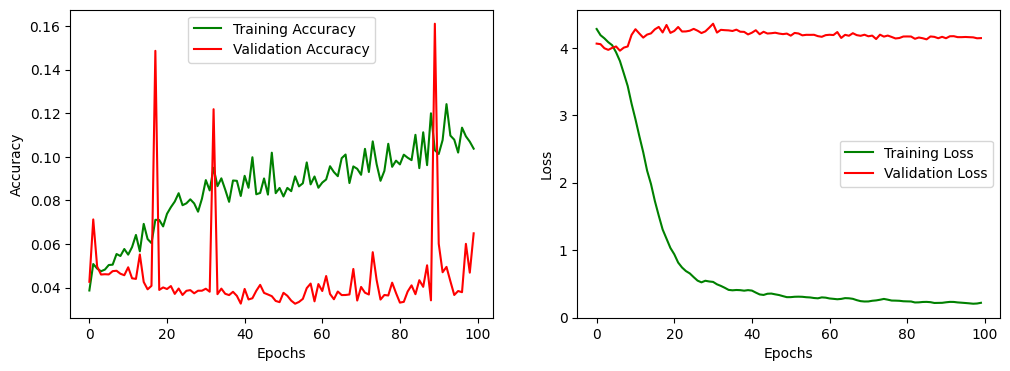

In [25]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', color='green')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', color='green')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

## Saving the Model

In [26]:
model_json = model.to_json()
with open("model_a.json","w") as json_file:
    json_file.write(model_json)

In [ ]:
model.save("Model_weights.weight.h5")